In [ ]:
import os
import zipfile
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
from datasets import load_dataset

# ---------- CONFIG ----------

MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

# Use raw strings for Windows paths
DATA_FILE  = r"C:\Users\HP\Desktop\Analyst\train_data_cleaned.jsonl"
OUTPUT_DIR = r"C:\Users\HP\Desktop\Analyst\finetuned-qwen2.5-3b"
HF_CACHE   = r"C:\Users\HP\hf_cache"

# ---------- SETUP ----------

os.environ["HF_HOME"] = HF_CACHE
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(HF_CACHE, exist_ok=True)

has_cuda = torch.cuda.is_available()
device = "cuda" if has_cuda else "cpu"

print("CUDA available:", has_cuda)
print("Device:", device)
if has_cuda:
    print("GPU:", torch.cuda.get_device_name(0))

# ---------- LOAD TOKENIZER & MODEL ----------

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=HF_CACHE)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# On CPU: use float32. On GPU: you can switch to bfloat16 if supported.
dtype = torch.bfloat16 if has_cuda else torch.float32

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=dtype,
    cache_dir=HF_CACHE,   # no device_map here
)

model.config.use_cache = False
model.gradient_checkpointing_enable()

# Move model to device (CPU or GPU)
model.to(device)

# ---------- LoRA CONFIG ----------

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# ---------- DATASET PREP ----------

dataset = load_dataset("json", data_files=DATA_FILE)

def format_example(example):
    # adjust keys if your JSONL uses different names
    return f"### Prompt:\n{example['prompt']}\n\n### Response:\n{example['completion']}"

def tokenize(example):
    text = format_example(example)
    tokens = tokenizer(
        text,
        truncation=True,
        max_length=1024,
        padding="max_length",
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

tokenized_dataset = dataset["train"].map(
    tokenize,
    batched=False,
    remove_columns=dataset["train"].column_names
)

# ---------- TRAINING ARGS ----------

use_bf16 = has_cuda and torch.cuda.is_bf16_supported()

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    max_steps=50,          # ↓ start small on CPU; you can increase later
    warmup_steps=5,
    logging_steps=5,
    bf16=use_bf16,
    fp16=False,            # keep False on CPU
    save_strategy="steps",
    save_steps=25,
    save_total_limit=2,
    report_to="none",
)

trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=training_args,
    tokenizer=tokenizer,
    max_seq_length=1024,  # deprecation warning but still works
)

trainer.train()

# ---------- SAVE MODEL & TOKENIZER ----------

model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

# ---------- ZIP THE OUTPUT DIR LOCALLY ----------

zip_path = os.path.join(os.path.dirname(OUTPUT_DIR), "finetuned-qwen2.5-3b.zip")

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            full_path = os.path.join(root, file)
            rel_path = os.path.relpath(full_path, path)
            ziph.write(full_path, rel_path)

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipdir(OUTPUT_DIR, zipf)

print("Training complete.")
print(f"Model dir: {OUTPUT_DIR}")
print(f"Zipped model: {zip_path}")


CUDA available: False
Device: cpu


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  78%|#######8  | 2.42G/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

trainable params: 9,232,384 || all params: 1,552,946,688 || trainable%: 0.5945074657965335


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

c:\Users\HP\anaconda3\Lib\site-packages\huggingface_hub\utils\_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
c:\Users\HP\anaconda3\Lib\site-packages\trl\trainer\sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\HP\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [3]:
!pip install transformers==4.41.2 accelerate==0.33.0 datasets==2.20.0 trl==0.9.6 peft==0.10.0 --quiet


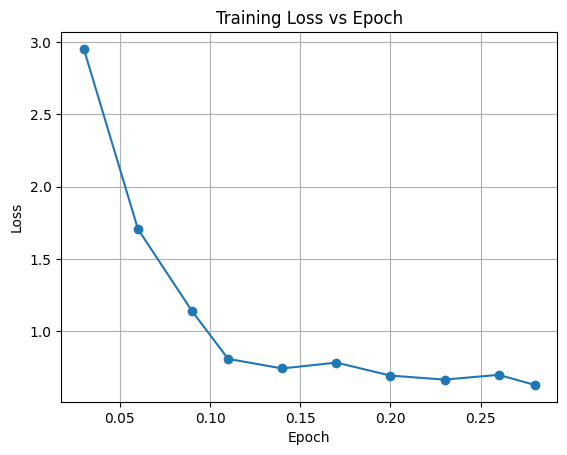

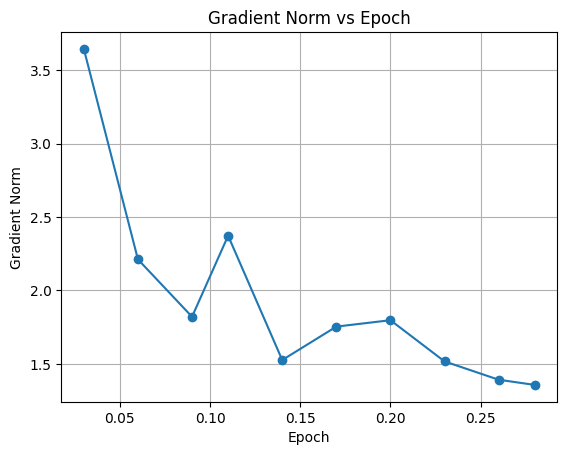

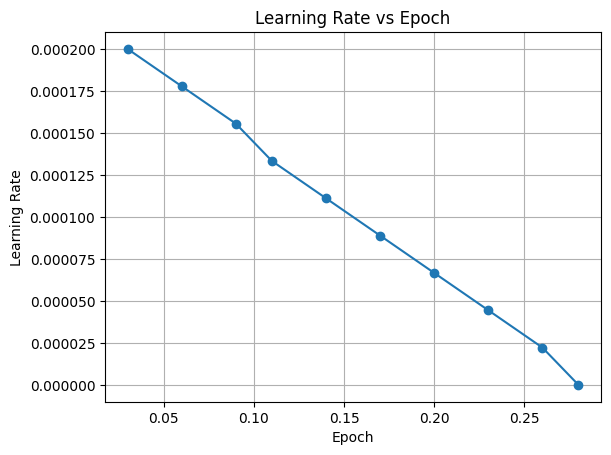

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- DATA ---------------- #

data = [
    [2.9528, 3.645212411880493, 0.0002, 0.03],
    [1.7059, 2.21175479888916, 0.00017777777777777779, 0.06],
    [1.1379, 1.8209199905395508, 0.00015555555555555556, 0.09],
    [0.8073, 2.372835874557495, 0.00013333333333333334, 0.11],
    [0.7411, 1.5261791944503784, 0.00011111111111111112, 0.14],
    [0.7815, 1.7538065910339355, 8.888888888888889e-05, 0.17],
    [0.6916, 1.7975136041641235, 6.666666666666667e-05, 0.20],
    [0.6638, 1.516750454902649, 4.4444444444444447e-05, 0.23],
    [0.6967, 1.392078161239624, 2.2222222222222223e-05, 0.26],
    [0.627, 1.3566814661026, 0.0, 0.28]
]

columns = ["loss", "grad_norm", "learning_rate", "epoch"]

df = pd.DataFrame(data, columns=columns)


plt.figure()
plt.plot(df["epoch"], df["loss"], marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.show()

# Plot 2: Gradient Norm vs Epoch
plt.figure()
plt.plot(df["epoch"], df["grad_norm"], marker='o')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm vs Epoch")
plt.grid(True)
plt.show()

# Plot 3: Learning Rate vs Epoch
plt.figure()
plt.plot(df["epoch"], df["learning_rate"], marker='o')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Epoch")
plt.grid(True)
plt.show()


In [1]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"
CACHE_DIR  = r"Z:\model\base_model_cache"

os.makedirs(CACHE_DIR, exist_ok=True)

print("Downloading model to:", CACHE_DIR)

AutoTokenizer.from_pretrained(
    MODEL_NAME,
    cache_dir=CACHE_DIR
)
AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    cache_dir=CACHE_DIR
)

print("\nDownload completed and saved at:\n", CACHE_DIR)


tokenizer_config.json: 0.00B [00:00, ?B/s]

c:\Users\HP\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in Z:\model\base_model_cache\models--Qwen--Qwen2.5-1.5B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]


Download completed and saved at:
 Z:\model\base_model_cache


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

BASE_MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"
CACHE_DIR       = r"/home/nineleaps/Desktop/Software_Analysis/Main Work/Analyst_Trainer/base_model_cache"     
ADAPTER_DIR     = r"/home/nineleaps/Desktop/Software_Analysis/Main Work/Analyst_Trainer/finetuned-qwen2 (1).5-3b"    

device = "cpu"
dtype = torch.bfloat16 if device == "cuda" and torch.cuda.is_bf16_supported() else torch.float32

print("Device:", device)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, cache_dir=CACHE_DIR)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    torch_dtype=dtype,
    cache_dir=CACHE_DIR,     
)
base_model.to(device)
model = PeftModel.from_pretrained(base_model, ADAPTER_DIR)
model.to(device)
model.eval()

def generate_answer(user_prompt, max_new_tokens=256):
    prompt_text = f"### Prompt:\n{user_prompt}\n\n### Response:\n"

    inputs = tokenizer(prompt_text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id,
        )

    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "### Response:" in full_text:
        return full_text.split("### Response:")[1].strip()
    return full_text

if __name__ == "__main__":
    test_prompt = "Question: Find the total revenue per product.\nColumns: product_id, quantity, price, sale_date"
    print("User:", test_prompt)
    ans = generate_answer(test_prompt, max_new_tokens=200)
    print("\nModel:\n", ans)
    


Device: cpu


In [13]:
import requests
import pandas as pd

API_URL = "https://startingly-mazier-anneliese.ngrok-free.dev/predict"

prompt = "Question: Get the average price of each product.\nColumns: product_id, quantity, price, sale_date"

payload = {
    "prompt": prompt,
    "max_tokens": 200
}

response = requests.post(API_URL, json=payload, verify=False)

print("Status:", response.status_code)
resp_json = response.json()
print("Raw Response:", resp_json)

model_output = resp_json.get("response", "")

if ":" in model_output:
    extracted_code = model_output.split(":", 1)[1].strip()
else:
    extracted_code = model_output.strip()

print("\nExtracted Code:\n", extracted_code)


data = {
    "product_id": [101, 102, 101, 103, 102],
    "quantity":   [2, 5, 4, 3, 1],
    "price":      [100, 150, 100, 200, 150],
    "sale_date":  ["2024-01-01", "2024-01-01", "2024-01-02", "2024-01-02", "2024-01-03"]
}

df = pd.DataFrame(data)
df["revenue"] = df["quantity"] * df["price"]

print("\nSample DF:\n", df)

print("\nRunning extracted code...")

local_vars = {"df": df}
try:
    result = eval(extracted_code, {}, local_vars)
    print("\nExecution Result:\n", result)
except Exception as e:
    print("\nError executing code:", e)


/home/nineleaps/.local/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'startingly-mazier-anneliese.ngrok-free.dev'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Status: 200
Raw Response: {'response': "df.groupby('product_id')['price'].mean()"}

Extracted Code:
 df.groupby('product_id')['price'].mean()

Sample DF:
    product_id  quantity  price   sale_date  revenue
0         101         2    100  2024-01-01      200
1         102         5    150  2024-01-01      750
2         101         4    100  2024-01-02      400
3         103         3    200  2024-01-02      600
4         102         1    150  2024-01-03      150

Running extracted code...

Execution Result:
 product_id
101    100.0
102    150.0
103    200.0
Name: price, dtype: float64


In [ ]:
get the average price of each product 
which product had most revenue
which day had most revenue
products which sold more than 4 quantity over all 
which day had least quantity sold